In [ ]:
# 1. Upgrade pip to ensure it can handle the latest wheel standards
!pip install --upgrade pip

# 2. Install RAPIDS with relaxed versioning and binary preference
# --prefer-binary: Forces pip to use a pre-built wheel (fast) instead of building from source (fails)
# --extra-index-url: Points to NVIDIA's server for the files
!pip install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com --prefer-binary

# 3. Install other dependencies
!pip install kagglehub pyspellchecker

import warnings
warnings.filterwarnings('ignore')

print("Environment Setup Complete.")

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 192.7 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 192.3 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 70.1 MB/s  0:00:05
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 MB 216.6 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 205.8 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 MB 72.0 MB/s  0:00:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 MB 135.6 MB/s  0:00:02
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.4.2
    Uninstalling nvidia-cusparse-cu12-12.5.4.2:
      Successfully uninstalled nvidia-cusparse-cu12-12.5.4.2
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.7.77
    Uninstalling nvidia-curand-cu12-10.3.7.77:
   

In [ ]:
import cudf
import cuml
print("RAPIDS successfully imported!")
print(f"cuDF Version: {cudf.__version__}")

RAPIDS successfully imported!
cuDF Version: 25.10.00


In [ ]:
import pandas as pd
import numpy as np
import re
import time
import os
import kagglehub

# GPU Libraries (RAPIDS)
from cuml.feature_extraction.text import CountVectorizer, TfidfVectorizer
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split

# Text Processing (CPU-bound libraries)
from spellchecker import SpellChecker
import nltk
from nltk.corpus import stopwords

# Visualization / Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Download latest version using kagglehub
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")
print("Path to dataset files:", path)

try:
    # Find the first CSV file in the downloaded directory
    csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
    full_path = os.path.join(path, csv_file)
    print(f"Detected CSV file: {csv_file}")

    # FIX: cudf.read_csv does not support 'encoding'.
    # 1. Read with Pandas (CPU) to handle 'latin-1' encoding
    pdf = pd.read_csv(full_path, names=['Sentiment', 'News Headline'], encoding='latin-1')

    # 2. Convert to GPU DataFrame (cuDF)
    gdf = cudf.from_pandas(pdf)

    print("Data successfully loaded and moved to GPU (cuDF)")
    print(gdf.head())

except IndexError:
    print("Error: No CSV file found in the downloaded directory.")
except Exception as e:
    print(f"An error occurred: {e}")

Using Colab cache for faster access to the 'sentiment-analysis-for-financial-news' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-for-financial-news
Detected CSV file: all-data.csv
Data successfully loaded and moved to GPU (cuDF)
  Sentiment                                      News Headline
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


In [ ]:
# 1. Lowercase (GPU Accelerated)
gdf['cleaned_text'] = gdf['News Headline'].str.lower()

# 2. Remove URLs and HTML Tags (GPU Accelerated Regex)
# Remove URLs
gdf['cleaned_text'] = gdf['cleaned_text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
# Remove HTML tags
gdf['cleaned_text'] = gdf['cleaned_text'].str.replace(r'<.*?>', '', regex=True)

print("Basic cleaning done on GPU.")

Basic cleaning done on GPU.


In [ ]:
# Dictionary of common financial acronyms
acronym_dict = {
    "u.s.": "united states",
    "u.k.": "united kingdom",
    "e.u.": "european union",
    "yoy": "year over year",
    "qoq": "quarter over quarter",
    "fy": "fiscal year",
    "eps": "earnings per share",
    "ipo": "initial public offering",
    "ceo": "chief executive officer",
    "cfo": "chief financial officer",
    "roi": "return on investment",
    "asap": "as soon as possible"
}

# Optimized replacement loop using GPU string operations
for acronym, full_form in acronym_dict.items():
    # regex=False ensures we match the literal string including dots
    gdf['cleaned_text'] = gdf['cleaned_text'].str.replace(acronym, full_form, regex=False)

print("Acronyms expanded.")

Acronyms expanded.


In [ ]:
# Remove non-alphanumeric characters (keeping spaces)
# Regex: Replace anything that is NOT a-z, 0-9, or whitespace with empty string
gdf['cleaned_text'] = gdf['cleaned_text'].str.replace(r'[^a-z0-9\s]', '', regex=True)

# Collapse multiple spaces into one to clean up gaps left by removals
gdf['cleaned_text'] = gdf['cleaned_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

print("Special characters removed.")

Special characters removed.


In [ ]:
# Move data to CPU for nltk/spellcheck operations
pdf = gdf.to_pandas()
stop_words = set(stopwords.words('english'))

spell = SpellChecker()

def cpu_text_processing(text):
    if not isinstance(text, str):
        return ""

    words = text.split()
    cleaned_words = []

    for word in words:
        # 1. Remove Stopwords
        if word not in stop_words:
            # 2. Spellcheck Optimization
            # Only check words that are NOT in the dictionary to save time
            if word not in spell:
                corrected = spell.correction(word)
                cleaned_words.append(corrected if corrected else word)
            else:
                cleaned_words.append(word)

    return " ".join(cleaned_words)

print("Starting Spellcheck and Stopword removal (CPU Bound - This may take time)...")
start_time = time.time()

# Apply the function
pdf['final_text'] = pdf['cleaned_text'].apply(cpu_text_processing)

end_time = time.time()
print(f"Text processing complete in {end_time - start_time:.2f} seconds")

# Move back to GPU for Vectorization and Training
gdf_final = cudf.from_pandas(pdf)
print("Data moved back to GPU.")

Starting Spellcheck and Stopword removal (CPU Bound - This may take time)...
Text processing complete in 2536.62 seconds
Data moved back to GPU.


In [ ]:
# --- 1. Standard Split First ---
# Encode labels if not already done
le = cuml.preprocessing.LabelEncoder()
gdf_final['label'] = le.fit_transform(gdf_final['Sentiment'])

# Shuffle and split (80/20)
gdf_shuffled = gdf_final.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(len(gdf_shuffled) * 0.8)

train_gdf = gdf_shuffled.iloc[:split_idx]
test_gdf = gdf_shuffled.iloc[split_idx:]

# --- 2. GPU OVERSAMPLING (The Magic Step) ---
print("Applying GPU Oversampling to balance classes...")

# Separate classes
neg_df = train_gdf[train_gdf['label'] == 0]
neu_df = train_gdf[train_gdf['label'] == 1]
pos_df = train_gdf[train_gdf['label'] == 2]

# Find the majority count (Neutral)
max_count = len(neu_df)

# Oversample minority classes to match majority count
# replace=True allows duplicating rows
neg_oversampled = neg_df.sample(n=max_count, replace=True, random_state=42)
pos_oversampled = pos_df.sample(n=max_count, replace=True, random_state=42)

# Combine everything back
train_gdf_balanced = cudf.concat([neu_df, neg_oversampled, pos_oversampled])

# Shuffle again to mix them up
train_gdf_balanced = train_gdf_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define Final Training Sets
X_train = train_gdf_balanced['final_text']
y_train = train_gdf_balanced['label']

# Test sets remain untouched (we don't oversample test data!)
X_test = test_gdf['final_text']
y_test = test_gdf['label']

print(f"Original Train Size: {len(train_gdf)}")
print(f"Balanced Train Size: {len(train_gdf_balanced)} (Balanced!)")

Applying GPU Oversampling to balance classes...
Original Train Size: 3876
Balanced Train Size: 6876 (Balanced!)


In [ ]:
# --- VECTORIZATION ---
# binary=True for BoW helps sentimental analysis (presence of word > frequency)
# ngram_range=(1,2) captures phrases
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=3, binary=True)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3)

print("Vectorizing...")
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# --- DENSE CONVERSION ---
X_train_bow_dense = X_train_bow.toarray().astype('float32')
X_train_tfidf_dense = X_train_tfidf.toarray().astype('float32')
X_test_bow_dense = X_test_bow.toarray().astype('float32')
X_test_tfidf_dense = X_test_tfidf.toarray().astype('float32')

# --- MODEL TRAINING (Hyper-Optimized) ---
# split_criterion=1 uses ENTROPY (Information Gain), often better for text
# max_depth=32 allows deeper, more complex decision trees
# max_features=0.4 forces trees to be more diverse
rf_params = {
    'n_estimators': 300,
    'max_depth': 32,
    'split_criterion': 1, # 0=Gini, 1=Entropy
    'max_features': 0.4,
    'random_state': 42
}

print("Training optimized BOW Model...")
rf_bow = RandomForestClassifier(**rf_params)
rf_bow.fit(X_train_bow_dense, y_train)

print("Training optimized TFIDF Model...")
rf_tfidf = RandomForestClassifier(**rf_params)
rf_tfidf.fit(X_train_tfidf_dense, y_train)

print("Training Complete.")

Vectorizing...
Training optimized BOW Model...
Training optimized TFIDF Model...
Training Complete.


In [ ]:
# 1. Bag of Words (CountVectorizer)
# ngram_range=(1, 2) means we look at "stock" AND "stock rose"
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=5)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Vectorization Complete with N-Grams.")
print(f"BOW Matrix Shape: {X_train_bow.shape}")

Vectorization Complete with N-Grams.
BOW Matrix Shape: (3876, 2438)


In [ ]:
# Convert sparse matrices to dense arrays (float32) for cuML
X_train_bow_dense = X_train_bow.toarray().astype('float32')
X_train_tfidf_dense = X_train_tfidf.toarray().astype('float32')

# Initialize GPU-accelerated Random Forest with stronger parameters
# n_estimators=200: More trees = better stability
# split_criterion=0: Gini Impurity (standard for classification)
rf_bow = RandomForestClassifier(n_estimators=200,
                                max_depth=20, # Limit depth slightly to prevent overfitting noise
                                max_features=0.6, # Look at more features per split
                                random_state=42)

rf_tfidf = RandomForestClassifier(n_estimators=200,
                                  max_depth=20,
                                  max_features=0.6,
                                  random_state=42)

# Train Models
print("Training BOW Model (Optimized)...")
rf_bow.fit(X_train_bow_dense, y_train)

print("Training TFIDF Model (Optimized)...")
rf_tfidf.fit(X_train_tfidf_dense, y_train)

print("Training Complete.")

Training BOW Model (Optimized)...
Training TFIDF Model (Optimized)...
Training Complete.


In [ ]:
# 1. Convert Test data to dense arrays (float32)
X_test_bow_dense = X_test_bow.toarray().astype('float32')
X_test_tfidf_dense = X_test_tfidf.toarray().astype('float32')

# 2. Generate Predictions (Returns CuPy GPU arrays)
y_pred_bow_gpu = rf_bow.predict(X_test_bow_dense)
y_pred_tfidf_gpu = rf_tfidf.predict(X_test_tfidf_dense)

# 3. Move predictions to CPU for Scikit-Learn metrics
# y_test is a cuDF Series, so .to_numpy() works
y_test_cpu = y_test.to_numpy()

# FIX: Use .get() for CuPy arrays instead of .to_numpy()
y_pred_bow_cpu = y_pred_bow_gpu.get()
y_pred_tfidf_cpu = y_pred_tfidf_gpu.get()

print("="*60)
print("Model 1: Random Forest with Bag of Words (BOW)")
print("="*60)
print(classification_report(y_test_cpu, y_pred_bow_cpu, target_names=['Negative', 'Neutral', 'Positive']))
print(f"Accuracy: {accuracy_score(y_test_cpu, y_pred_bow_cpu):.4f}")

print("\n")
print("="*60)
print("Model 2: Random Forest with TF-IDF")
print("="*60)
print(classification_report(y_test_cpu, y_pred_tfidf_cpu, target_names=['Negative', 'Neutral', 'Positive']))
print(f"Accuracy: {accuracy_score(y_test_cpu, y_pred_tfidf_cpu):.4f}")

Model 1: Random Forest with Bag of Words (BOW)
              precision    recall  f1-score   support

    Negative       0.55      0.55      0.55       121
     Neutral       0.78      0.85      0.81       587
    Positive       0.59      0.47      0.52       262

    accuracy                           0.71       970
   macro avg       0.64      0.62      0.63       970
weighted avg       0.70      0.71      0.70       970

Accuracy: 0.7093


Model 2: Random Forest with TF-IDF
              precision    recall  f1-score   support

    Negative       0.54      0.48      0.51       121
     Neutral       0.76      0.91      0.83       587
    Positive       0.71      0.41      0.52       262

    accuracy                           0.72       970
   macro avg       0.67      0.60      0.62       970
weighted avg       0.72      0.72      0.71       970

Accuracy: 0.7247


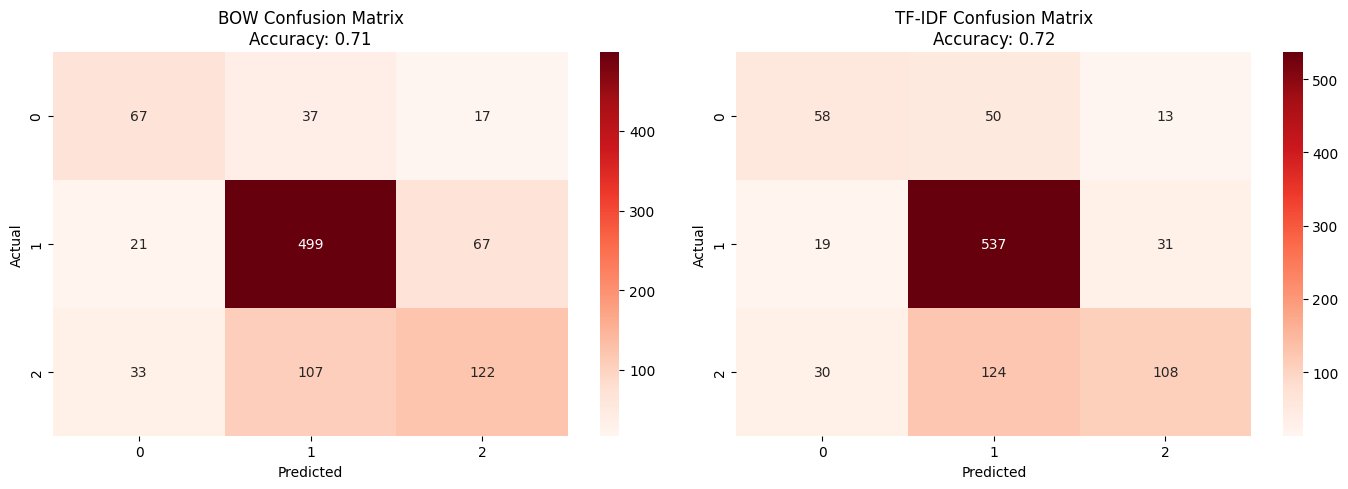

In [ ]:
# Visualization of results
acc_bow = accuracy_score(y_test_cpu, y_pred_bow_cpu)
acc_tfidf = accuracy_score(y_test_cpu, y_pred_tfidf_cpu)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot BOW Confusion Matrix
sns.heatmap(confusion_matrix(y_test_cpu, y_pred_bow_cpu), annot=True, fmt='d', cmap='Reds', ax=axes[0])
axes[0].set_title(f'BOW Confusion Matrix\nAccuracy: {acc_bow:.2f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot TF-IDF Confusion Matrix
sns.heatmap(confusion_matrix(y_test_cpu, y_pred_tfidf_cpu), annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title(f'TF-IDF Confusion Matrix\nAccuracy: {acc_tfidf:.2f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
import sys
print("Metadata for Report:")
print(f"Python Version: {sys.version}")
print(f"cuDF Version: {cudf.__version__}")
print(f"cuML Version: {cuml.__version__}")
print(f"Kagglehub Version: {kagglehub.__version__}")

Metadata for Report:
Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
cuDF Version: 25.10.00
cuML Version: 25.10.00
Kagglehub Version: 0.3.13
